In [1]:
import torch
from utils import models, nethook, activ, matching, helpers, dictionary, neuron_finding,cam
import os 
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import pandas as pd
import matplotlib.gridspec as gridspec
from sklearn.metrics import roc_auc_score, accuracy_score

/export/home/wuyueting/miniconda3/envs/mae-wyt/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
def reshape_transform(tensor, height=14, width=14):
    # 去掉类别标记
    result = tensor[:, 1:, :].reshape(tensor.size(0),
    height, width, tensor.size(2))

    # 将通道维度放到第一个位置
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def draw_bar_chart(label_number,pkl_file,save_path,methods="abs"):
    print(f"Draw bar chart for label {label_number}...")
    f = open(pkl_file,"rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()

    weights = data[:, :, 0]
    activation =data[:,:,2]

    plt.clf()
    sample_number = weights.shape[0]
    if methods=="abs":
        weights = np.abs(weights)
    weight_accumulator = np.sum(weights, axis=0)
    average_gradients = weight_accumulator / sample_number

    # 估计每个卷积核的Shapley值
    importance = average_gradients.flatten()
    categories = list(range(importance.shape[0]))
    dot_size = 4
    plt.figure(figsize=(20, 10))
    plt.scatter(categories, importance, s=dot_size)  # 绘制散点图，每个点的大小为1

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 添加标题和标签
    plt.title(f'Neuron Weight for identifying class {label_number}')
    plt.xlabel('Neuron')
    plt.ylabel('Values')
    plt.savefig(os.path.join(save_path,"weight_plot.png"), format='png')

    print(f"Draw Finish! in {save_path}/weight_plot.png")

    plt.clf()
    sample_number = weights.shape[0]
    if methods=="abs":
        activation = np.abs(activation)
    activation_accumulator = np.sum(activation, axis=0)
    average_activation = activation_accumulator / sample_number

    # 估计每个卷积核的Shapley值
    importance = average_activation.flatten()
    categories = list(range(importance.shape[0]))
    dot_size = 4
    plt.figure(figsize=(20, 10))
    plt.scatter(categories, importance, s=dot_size)  # 绘制散点图，每个点的大小为1

    directory_path = os.path.dirname(save_path)
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)

    # 添加标题和标签
    plt.title(f'Neuron Activation for identifying class {label_number}')
    plt.xlabel('Neuron')
    plt.ylabel('Values')
    plt.savefig(os.path.join(save_path,"activation_plot.png"), format='png')

    print(f"Draw Finish! in {save_path}/activation_plot.png")

In [ ]:

def thyroid_main():
    label = "all"
    folder_path = f"/export/home/wuyueting/thyroid_data/BM/8_select5_nodlue811_val_test/test/"
    model_name = "thyroid_vit_small_5_nodule811"
    target_layer="model.blocks[-1]"
    target_save_name = model_name+"_8_select_last_block"
    weight_state = "weight_true"

    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    # activ.get_same_class_similarity_matrix(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}_similarity.pkl")
    print(f"activs_stats/{target_save_name}/{label}.pkl")
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    # f.close()

    # weights = data[:,:,0]
    # activation =data[:,:,1]
    # idexs,_ = neuron_finding.get_positve_weight_neuron(weights,10)
    # print("highest weight neuron",idexs)
    # idexs,_ = neuron_finding.get_max_activate_neuron(activation,10)
    # print("max activate neuron",idexs)
    # idexs,_ = neuron_finding.get_max_weighted_activate_neuron(weights,activation,10)
    # print("max weighted-activate neuron",idexs)
    

    # activ.get_sample_stats(model_name,image_files, reshape_transform, target_layer=target_layer,\
    #                        save=f"activs_stats/dogvscat_{target_save_name}/sample_stat.pkl")
    
    
    

    # idxs, critical_neuron_activ_dic = neuron_finding.visualize_one_class_with_max_sample(model_name,target_layer,image_files,label,\
    #                                                                                     20,10,\
    #                                                                                     f"activs_stats/{target_save_name}",\
    #                                                                                     f"matching_result/{target_save_name}/{weight_state}_SampleRepresent/{label}/",visualize=False)
    draw_bar_chart(label,f"activs_stats/{target_save_name}/{label}.pkl",save_path=f"matching_result/{target_save_name}/{weight_state}/{label}",methods=None)

    
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_04_20_11_43/descriptions.csv"
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_05_26_19_16/descriptions.csv"
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_05_28_16_02/descriptions.csv"
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_05_29_11_53/descriptions.csv"
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_06_04_13_26/descriptions.csv"
    clipmodel_name = "biomedCLIP"
    if clipmodel_name == "biomedCLIP":
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_06_04_17_08/descriptions.csv" ##biomedCLIP
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_19_13_10/descriptions.csv" ##TIRADS1
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_30_14_48/descriptions.csv" ##TIRADS2
    elif clipmodel_name == "vit":
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_12_17_24/descriptions.csv" ##Vit-L/14
    elif clipmodel_name == "pubmedclip":    
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_12_17_29/descriptions.csv" #pubmedCLIP
    df = pd.read_csv(filename)

    # unique_descriptions = set()
    sentence_parts = {}

    # total_weight = np.sum(weights[max_weight_idxs])
    # for id in idxs:
    #     # activ.get_one_neuron_image_activs(model,model_name,target_layer, reshape_transform, id,image_path,
    #     #                         visualize=True,save_path = os.path.join("thyroid_sample_explain",str(id)+".jpg"),masked=False)
    #     target_row = df.iloc[id]
    #     description = target_row["description"]
    #     print(id,description)
    
    # df.to_csv(os.path.join(save_path,"descriptions.csv"), index=False)
    #         activation = sample_dic[sample_id]
            
    #         concept_dict = dictionary.make_concept_dic(model, processor, tokenizer, file_path, concepts)
    #         concpet_scores,scores = matching.matching_one_neuron(activation, concept_dict)
    #         scores_total = scores_total+np.array(scores)
    #         del scores
    #     print(explainer.do_neuron_description(concepts, scores_total))
    return

In [ ]:

import torch.nn as nn
from torchvision.transforms import ToPILImage
def thyroid_sample_explain(i,label,top_number:int=20,importance_matric = "ori_ori"):
    label = "all"
    folder_path = f"/export/home/wuyueting/thyroid_data/BM/8_select5_nodlue811_val_test/test/"
    model_name = "thyroid_vit_small_5_nodule811"
    target_layer="model.blocks[-1]"
    target_save_name = model_name+"_8_select_last_block"
    weight_state = "weight_true"

    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    # device = "cpu"
    model,_ = models.load(model_name, device)
    model.eval()
    with open('model_structure.txt', 'w') as f:
    # 使用print的file参数将输出重定向到文件
    
        print(model, file=f)

    preprocess =transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.22,), (0.08,))
        ])
    

    if isinstance(i,str):
        index = image_files.index(i)
        image_path = i
        i = index
        del index
    else:
        image_path = image_files[i]
    print(image_path)
    
    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()
    
    batch_norm = nn.BatchNorm1d(num_features=384)
    # 应用BatchNorm
    norm_activation = batch_norm(torch.from_numpy(data[:, :, 2]).cpu().float()).detach().numpy()
    ori_gradients = data[i, :, 0]
    ori_activations = norm_activation[i,:]
    # ori_activations = data[i, :, 2]
    ## Standardization
    stn_gradients = ori_gradients/np.max(np.abs(ori_gradients))
    stn_activations = (ori_activations - np.min(ori_activations)) / (np.max(ori_activations) - np.min(ori_activations))
    abs_gradients = np.abs(ori_gradients)
    
     # 第一个字母代表着gradients，第二个字母代表着activation
    #第一个选择有 abs, stn, ori, 第二个选择有stn, ori
    gradient_type = importance_matric.split("_")[0]
    activation_type = importance_matric.split("_")[1]
    
    if gradient_type == "abs":
        gradients = abs_gradients
    elif gradient_type == "stn":
        gradients = stn_gradients
    elif gradient_type == "ori":
        gradients = ori_gradients
    elif gradient_type == "stnabs":
        gradients = np.abs(stn_gradients)
        
    if activation_type == "stn":
        activations = stn_activations
    elif activation_type == "ori":
        activations = ori_activations
    # print(gradients,activations)
    
    ## 方案1
    ##step1:找出最大激活的10个neuron
    # max_weight_idxs,_ = neuron_finding.get_max_activate_neuron(max_activations, k=20)
    ## 方案2
    ##step1:找出最大权重的10个neuron
    # max_weight_idxs, top_k_values = neuron_finding.get_positve_weight_neuron(weights, k=20)
    ##step1 or : 找出所有的正权重
    top_important_idxs, top_k_values = neuron_finding.get_max_weighted_activate_neuron(gradients, activations, k=top_number)
    positive_mask = top_k_values >= 0
    # 使用 np.argmax 找到第一个 False 的位置
    first_non_positive_index = np.argmax(~positive_mask)
    # 如果所有元素都是正数，则 np.argmax(~positive_mask) 将返回0（如果第一个元素为正数）
    # 需要检查是否所有元素都是正数
    if positive_mask.all():
        first_non_positive_index = len(top_k_values)
    print(first_non_positive_index)
    
    ##step2:根据descrption找到neuron对应的内容
    # filename = '/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_04_16_18_33/descriptions.csv'
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_04_17_15_08/descriptions.csv"
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_04_17_15_25/descriptions.csv"
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_04_20_11_43/descriptions.csv"
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_05_26_19_16/descriptions.csv"
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_05_28_16_02/descriptions.csv"
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_05_28_17_35/descriptions.csv"
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_05_28_21_37/descriptions.csv"
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_05_28_21_55/descriptions.csv"
    # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_06_04_13_26/descriptions.csv"
    clipmodel_name = "biomedCLIP"
    if clipmodel_name == "biomedCLIP":
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_17_16_45/descriptions.csv" ##biomedCLIP
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_23_16_08/descriptions.csv" ##tirads2
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_31_16_14/descriptions.csv" ##TIRADS2
    elif clipmodel_name == "vit":
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_12_17_24/descriptions.csv" ##Vit-L/14
    elif clipmodel_name == "pubmedclip":    
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_12_17_29/descriptions.csv" #pubmedCLIP
    df = pd.read_csv(filename)

    # unique_descriptions = set()
    sentence_parts = {}

    total_value = 0
    for i in range(first_non_positive_index):
        id = top_important_idxs[i]
        value = top_k_values[i]
    # for id, value in  zip(top_important_idxs[::-1], top_k_values[::-1]):
        # activ.get_one_neuron_image_activs(model,model_name,target_layer, reshape_transform, id,image_path,
        #                         visualize=True,save_path = os.path.join("thyroid_sample_explain",str(id)+".jpg"),masked=False)
        target_row = df.iloc[id]
        description = target_row["description"] if target_row['similarity'] >1 else "Undefined"
        if description not in sentence_parts:
            sentence_parts[description]=value
        else:
            sentence_parts[description]=sentence_parts[description]+value
        
        total_value = total_value + value
    
    result_dict = {key: value / total_value for key, value in sentence_parts.items()}
    sorted_result_dict = {k: v for k, v in sorted(result_dict.items(), key=lambda item: item[1], reverse=True)}
    draw(sorted_result_dict, data ='TIRADS3')
    del sentence_parts
    print("The concepts most relevant to the results are as follows:")
    sentence = f"{', '.join([f'{key}({value:.0%})' for key, value in sorted_result_dict.items()])}."
    # sentence = f"This image has {', '.join(sentence_parts)}."
    # text = f"{', '.join([f'{key}' for key, _ in result_dict.items()])}."
    print(sentence)
    
    ##step3:得到分类
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')  # 不显示坐标轴
    plt.show()
    input_tensor = preprocess(image)
    input_tensor = input_tensor.unsqueeze(0).to(device)  # 添加批次维度
    output = model(input_tensor)
    prediction = output.argmax(dim=1).item()
    if prediction == 0:
        print("It's a liang.")
    elif prediction == 1:
        print("It's e.")
    
    return sorted_result_dict

In [ ]:
def draw(label_dict, data ='TIRADS3'):
    # 创建图形和子图
    categories, color_map = get_categories_and_colormap(data)
    organized_data = {category: {tag: label_dict[tag] for tag in tags if tag in label_dict} for category, tags in categories.items()}

    # 创建图形和子图
    fig = plt.figure(figsize=(10, 20), dpi=300)
    gs = gridspec.GridSpec(len(organized_data), 1, height_ratios=[len(values) for values in organized_data.values()])

    # 绘制每个分类的柱状图，数据按百分比从大到小排序，并确保每个图表的柱子宽度和间距一致
    for idx, (category, values) in enumerate(organized_data.items()):
        # 对每个类别中的标签和百分比按百分比降序排序
        sorted_values = sorted(values.items(), key=lambda x: x[1], reverse=False)
        tags, percentages = zip(*sorted_values)
        
        ax = fig.add_subplot(gs[idx])
        # ax.barh(tags, percentages, height=0.5, color=plt.cm.Paired(np.arange(len(tags))))  # 设置统一的柱子高度为0.5
        # ax.barh(tags, percentages, height=0.5, )
        # ax.set_title(category)
        # ax.set_xlabel('Percentage')
        # ax = fig.add_subplot(gs[idx])
        ax.barh(tags, percentages, height=0.5, color=color_map[category])  # 使用颜色映射设置颜色
        ax.set_title(category)
        ax.set_xlabel('Percentage')

    plt.tight_layout()
    plt.show()

    plt.tight_layout()
    plt.show()


activs_stats/thyroid_vit_small_5_nodule811_8_select_last_block/all.pkl exist!
<All keys matched successfully>
<All keys matched successfully>
/export/home/wuyueting/thyroid_data/BM/8_select5_nodlue811_val_test/test/1/b17160223075838.jpg
384


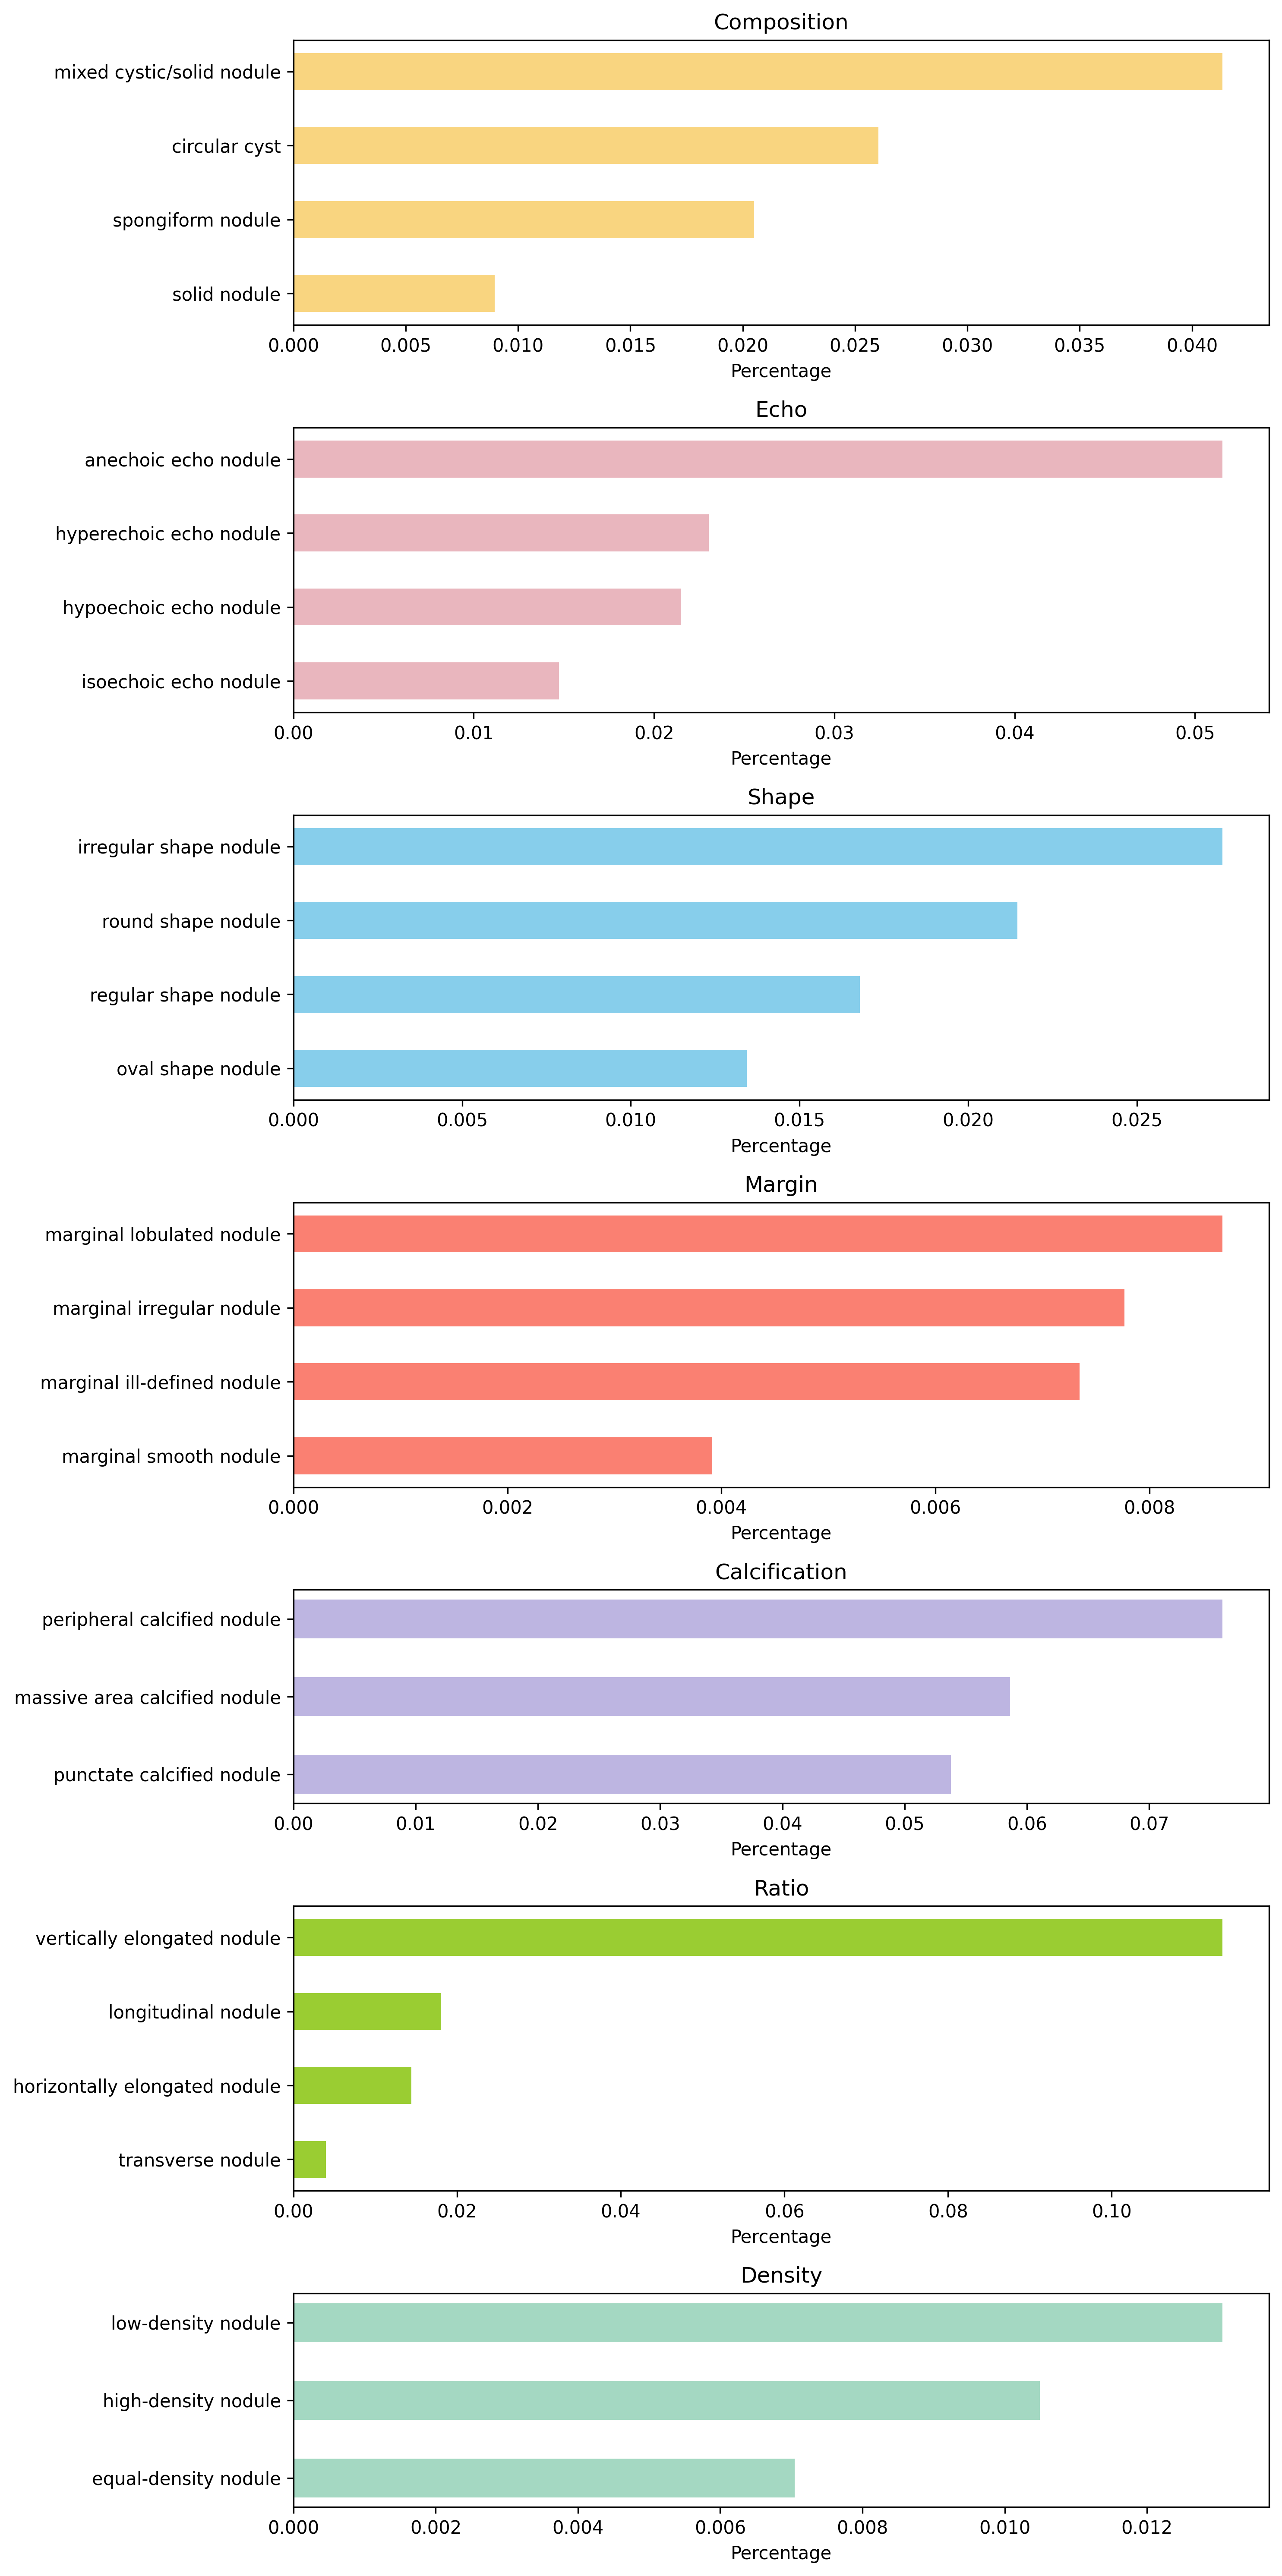

<Figure size 640x480 with 0 Axes>

The concepts most relevant to the results are as follows:
Undefined(32%), vertically elongated nodule(11%), peripheral calcified nodule(8%), massive area calcified nodule(6%), punctate calcified nodule(5%), anechoic echo nodule(5%), mixed cystic/solid nodule(4%), irregular shape nodule(3%), circular cyst(3%), hyperechoic echo nodule(2%), hypoechoic echo nodule(2%), round shape nodule(2%), spongiform nodule(2%), longitudinal nodule(2%), regular shape nodule(2%), isoechoic echo nodule(1%), horizontally elongated nodule(1%), oval shape nodule(1%), low-density nodule(1%), high-density nodule(1%), solid nodule(1%), marginal lobulated nodule(1%), marginal irregular nodule(1%), marginal ill-defined nodule(1%), equal-density nodule(1%), transverse nodule(0%), marginal smooth nodule(0%).


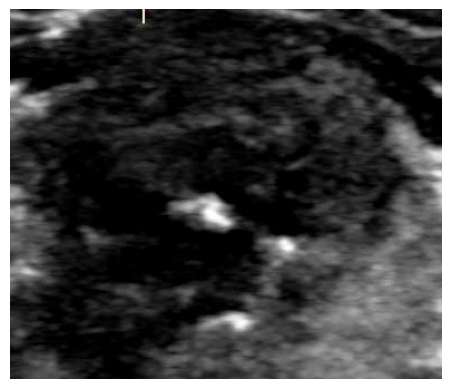

It's e.


{'Undefined': 0.31634860491803884,
 'vertically elongated nodule': 0.11355876139485264,
 'peripheral calcified nodule': 0.07600318417923418,
 'massive area calcified nodule': 0.05861247493060545,
 'punctate calcified nodule': 0.05379774959378704,
 'anechoic echo nodule': 0.05153547758820018,
 'mixed cystic/solid nodule': 0.041360887346785426,
 'irregular shape nodule': 0.027541995826043487,
 'circular cyst': 0.02604008057021662,
 'hyperechoic echo nodule': 0.023048094535502182,
 'hypoechoic echo nodule': 0.021511477117826243,
 'round shape nodule': 0.021462296439876696,
 'spongiform nodule': 0.020511505550598417,
 'longitudinal nodule': 0.018044421854201926,
 'regular shape nodule': 0.01678573093037188,
 'isoechoic echo nodule': 0.014723990404669374,
 'horizontally elongated nodule': 0.014414861883118468,
 'oval shape nodule': 0.013439108764797739,
 'low-density nodule': 0.0130631980893806,
 'high-density nodule': 0.010493856031600572,
 'solid nodule': 0.008958085050278704,
 'marginal 

In [ ]:
thyroid_sample_explain("/export/home/wuyueting/thyroid_data/BM/8_select5_nodlue811_val_test/test/1/b17160223075838.jpg","all",top_number=384,importance_matric="abs_stn")

In [ ]:
def get_categories_and_colormap(data:str):
    if data == 'TIRADS':
        categories = {
        'Composition': [
            "Benign appearance",
            "Mixed cystic and solid composition",
            "Cystic composition",
            "Spongiform composition",
            "Purely solid composition"
        ],
        'Echogenicity': [
            "Isoechoic echogenicity",
            "Hyperechoic echogenicity",
            "Hypoechoic echogenicity",
            "Very hypoechoic echogenicity"
        ],
        'Shape': [
            "Oval mass shape",
            "Round mass shape",
            "Taller-than-wide shape",
            "Wider-than-tall shape",
            "Irregular mass shape",
            "Nodule vertically elongated",  # 新增
            "Nodule horizontally elongated"  # 新增
        ],
        'Margin': [
            "Irregular margins",
            "Smooth margins",
            "Lobulated or irregular margins"
        ],
        'Echogenic Foci': [
            "Peripheral calcifications",
            "Round calcifications",
            "Punctate calcifications",
            "White spot calcification",  # 新增
            "Scattered white calcification",  # 新增
            "Massive area calcification"  # 新增
        ],
        'Asymmetry': [
            "Developing asymmetry",
            "High mass density",
            "Equal mass density",
            "Low mass density"
        ]
    }
        color_map = {
            'Echogenic Foci': '#bdb5e1',
            'Margin': '#FA8072',
            'Asymmetry':'yellowgreen',
            'Shape': 'skyblue',
            'Echogenicity': '#e9b6be',
            'Composition': '#f9d580',    
        }
    
    elif data == "TIRADS2":
        categories = {
        'Composition': [
            "mixed cystic/solid nodule",
            "spongiform nodule",
            "cystic nodule",
            "solid nodule",
        ],
        'Echo': [
            "anechoic echo nodule",
            "isoechoic echo nodule",
            "hypoechoic echo nodule",
            "hyperechoic echo nodule"
        ],
        'Shape': [
            "oval shape nodule",
            "Round shape nodule",
            "Irregular shape nodule",
            "Regular shape nodule"
            
        ],
        'Margin': [
            "marginal irregular nodule",
            "marginal smooth nodule",
            "marginal ill-defined nodule"
        ],
        'Calcification': [
            "punctate calcified nodule",
            "peripheral calcified nodule",
            "massive area calcified nodule"
        ],
        'Ratio': [
            "wider-than-tall nodule",
            "taller-than-wide nodule",
            "vertically elongated nodule",  # 新增
            "horizontally elongated nodule"  # 新增
        ],
        'Density': [
            "low-density nodule",
            "equal-density nodule",
            "high-density nodule"
        ]
    }
        color_map = {
            'Calcification': '#bdb5e1',
            'Margin': '#FA8072',
            'Ratio':'yellowgreen',
            'Shape': 'skyblue',
            'Echo': '#e9b6be',
            'Composition': '#f9d580',
            'Density':  '#a4d8c2'    
        }
    elif data == "TIRADS3":
        categories = {
        'Composition': [
            "mixed cystic-solid nodule",
            "mixed cystic/solid nodule",
            "spongiform nodule",
            "circular cyst",
            "solid nodule",
        ],
        'Echo': [
            "anechoic echo nodule",
            "isoechoic echo nodule",
            "hypoechoic echo nodule",
            "hyperechoic echo nodule"
        ],
        'Shape': [
            "oval shape nodule",
            "round shape nodule",
            "irregular shape nodule",
            "Regular shape nodule",
            "regular shape nodule",
            
        ],
        'Margin': [
            "marginal irregular nodule",
            "marginal smooth nodule",
            "marginal ill-defined nodule",
            "marginal lobulated nodule"
        ],
        'Calcification': [
            "punctate calcified nodule",
            "peripheral calcified nodule",
            "massive area calcified nodule"
        ],
        'Ratio': [
            "wider-than-tall nodule",
            "taller-than-wide nodule",
            "vertically elongated nodule",  # 新增
            "horizontally elongated nodule",  # 新增
            "transverse nodule",
            "longitudinal nodule"
        ],
        'Density': [
            "low-density nodule",
            "equal-density nodule",
            "high-density nodule"
        ]
    }
        color_map = {
            'Calcification': '#bdb5e1',
            'Margin': '#FA8072',
            'Ratio':'yellowgreen',
            'Shape': 'skyblue',
            'Echo': '#e9b6be',
            'Composition': '#f9d580',
            'Density':  '#a4d8c2'    
        }
    return categories, color_map

In [ ]:
def get_thyroid_sample_dict(clipmodel_name, ori_gradients, ori_activations,label_data="TIRADS", top_number:int=25,importance_matric = "abs_ori", only_pos=False):
    
    ## Standardization
    stn_gradients = ori_gradients/np.max(np.abs(ori_gradients))
    stn_activations = (ori_activations - np.min(ori_activations)) / (np.max(ori_activations) - np.min(ori_activations))
    abs_gradients = np.abs(ori_gradients)
        
    gradient_type = importance_matric.split("_")[0]
    activation_type = importance_matric.split("_")[1]

    if gradient_type == "abs":
        gradients = abs_gradients
    elif gradient_type == "stn":
        gradients = stn_gradients
    elif gradient_type == "ori":
        gradients = ori_gradients
    elif gradient_type == "stnabs":
        gradients = np.abs(stn_gradients)
    elif gradient_type =="sq":
        gradients = ori_gradients**2
        
    if activation_type == "stn":
        activations = stn_activations
    elif activation_type == "ori":
        activations = ori_activations
    elif activation_type == "abs":
        activations = np.abs(ori_activations)
    elif activation_type == "pos":
        min_act = np.min(ori_activations)
        if min_act < 0 :
            activations = ori_activations + np.abs(min_act)
        else:
            activations =  ori_activations
    elif activation_type == "sq":
        activations = ori_activations **2
        
    
    
    top_important_idxs, top_k_values = neuron_finding.get_max_weighted_activate_neuron(gradients, activations, k=top_number,only_pos=only_pos)
    positive_mask = top_k_values >= 0
    # 使用 np.argmax 找到第一个 False 的位置
    first_non_positive_index = np.argmax(~positive_mask)
    # 如果所有元素都是正数，则 np.argmax(~positive_mask) 将返回0（如果第一个元素为正数）
    # 需要检查是否所有元素都是正数
    if positive_mask.all():
        first_non_positive_index = len(top_k_values)
    
    
    if clipmodel_name == "biomedclip":
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_17_16_45/descriptions.csv" ##biomedCLIP
        # filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_23_16_08/descriptions.csv" ##tirads2
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_30_14_48/descriptions.csv" ##TIRADS2
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_31_16_14/descriptions.csv" ## TIRADS2 
    elif clipmodel_name == "vit":
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_12_17_24/descriptions.csv" ##Vit-L/14
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_08_02_11_17/descriptions.csv" ##vit-L/14
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_08_02_14_43/descriptions.csv" ##resnet50
    elif clipmodel_name == "pubmedclip":    
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_07_12_17_29/descriptions.csv" #pubmedCLIP
        filename = "/export/home/wuyueting/Interpretability/CLIP-dissect/results/thyroid_vit_24_08_02_12_45/descriptions.csv" ##pubmedCLIP
    df = pd.read_csv(filename)

    # print(filename)
    # unique_descriptions = set()
    sentence_parts = {}
    
    categories, _ = get_categories_and_colormap(label_data)
    for category, tags in categories.items():
        for tag in tags:
            sentence_parts[tag]=0
    total_value = 0
    for i in range(first_non_positive_index):
        id = top_important_idxs[i]
        value = top_k_values[i]
        target_row = df.iloc[id]
        description = target_row["description"] if target_row['similarity'] > 1 else "Undefined"
        if description not in sentence_parts:
            sentence_parts[description]=value
        else:
            sentence_parts[description]=sentence_parts[description]+value
        
        total_value = total_value + value
    
    result_dict = {key: value / total_value for key, value in sentence_parts.items()}
    del sentence_parts
    
    return result_dict

In [ ]:



def label_auc(label_data="TIRADS"):
    label = "all"
    folder_path = f"/export/home/wuyueting/thyroid_data/BM/8_select5_nodlue811_val_test/test/"
    model_name = "thyroid_vit_small_5_nodule811"
    target_layer="model.blocks[-1]"
    target_save_name = model_name+"_8_select_last_block"
    weight_state = "weight_true"

    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()
    
    tag_csv="/export/home/wuyueting/thyroid_data/BM/filtered_thyroid_test.csv"
    tag_df = pd.read_csv(tag_csv)
    
    num = tag_df.shape[0]
    
    ratio_trues, composition_trues, margin_trues, echo_trues, cal_trues = [], [], [], [], []
    ratio_scores, composition_scores, margin_scores, echo_scores, cal_scores = [], [], [], [], []
    
    for i in range(num):
        image_name = tag_df.iloc[i, 0]
        label = tag_df.iloc[i, 1]
        image_path = os.path.join("/export/home/wuyueting/thyroid_data/BM/5_nodule811/test",str(label), image_name)
        # 
        
        index = image_files.index(image_path)
        ori_gradients = data[index, :, 0]
        ori_activations = data[index, :, 2]
        label_dict = get_thyroid_sample_dict(ori_gradients,ori_activations,100,importance_matric = "abs_stn",only_pos=False)
        categories, _ = get_categories_and_colormap(label_data)
        # print(label_dict)
        organized_data = {category: {tag: label_dict[tag] for tag in tags if tag in label_dict} for category, tags in categories.items()}
        if not pd.isnull(tag_df.loc[i, 'Ratio']):
            ratio_trues.append(tag_df.loc[i, 'Ratio'])
            ratio_dict = organized_data['Shape']
            ratio = (ratio_dict["Taller-than-wide shape"]+ratio_dict["Nodule vertically elongated"])/(ratio_dict["Taller-than-wide shape"]+ratio_dict["Nodule vertically elongated"]+ratio_dict["Wider-than-tall shape"]+ ratio_dict["Nodule horizontally elongated"])
            
            ratio_scores.append(ratio)
        if not pd.isnull(tag_df.loc[i, 'Composition']):
            composition_trues.append(tag_df.loc[i, 'Composition'])
            composition_dict = organized_data['Composition']
            composition = (composition_dict["Purely solid composition"]+composition_dict["Mixed cystic and solid composition"])/(composition_dict["Mixed cystic and solid composition"]+composition_dict["Purely solid composition"]+composition_dict["Cystic composition"]+ composition_dict["Spongiform composition"])
            composition_scores.append(composition)
        
        if not pd.isnull(tag_df.loc[i, 'Margin']):
            margin_trues.append(tag_df.loc[i, 'Margin'])
            margin_dict = organized_data['Margin']
            margin = 1-margin_dict["Smooth margins"]/(margin_dict["Smooth margins"]+margin_dict["Irregular margins"]+margin_dict["Lobulated or irregular margins"])
            margin_scores.append(margin)
        if not pd.isnull(tag_df.loc[i,"Echo"]):
            echo_trues.append(tag_df.loc[i, 'Echo'])
            echo_dict = organized_data["Echogenicity"]
            echo = 1-(echo_dict["Isoechoic echogenicity"]+echo_dict["Hyperechoic echogenicity"])/(echo_dict["Very hypoechoic echogenicity"]+echo_dict["Isoechoic echogenicity"]+echo_dict["Hyperechoic echogenicity"]+echo_dict["Hypoechoic echogenicity"])
            echo_scores.append(echo)
        if not pd.isnull(tag_df.loc[i, 'Calcification']):
            cal_trues.append(tag_df.loc[i, 'Calcification'])
            cal_dict = organized_data['Echogenic Foci']
            cal = 1-cal_dict["White spot calcification"]/sum(cal_dict.values())
            cal_scores.append(cal)
        # print(f"Image {i+1}/{num} finished.")
            
        # if i==268:
        #     print(ratio)
        #     break
        
        del label_dict
            
    # ratio_preds = [0 if x<0.5 else 1 for x in ratio_scores]
    # composition_preds = [0 if x<0.5 else 1 for x in composition_scores]
    # margin_preds = [0 if x<0.5 else 1 for x in margin_scores]
    # echo_preds = [0 if x<0.5 else 1 for x in echo_scores]
    
    # 计算ACC
    scores = [ratio_scores, composition_scores, margin_scores, echo_scores, cal_scores]
    trues = [ratio_trues, composition_trues, margin_trues, echo_trues, cal_trues]
    categories = ['Ratio', 'Composition', 'Margin', 'Echo', "Calcification"]

    # 循环遍历每一组评分和真实值
    for category, true_values, pred_scores in zip(categories, trues, scores):
        # 计算预测值
        
        true_values_series = pd.Series(true_values)
        pred_scores_series = pd.Series(pred_scores)

        # 检查哪些位置有NaN
        nan_in_true_values = true_values_series.isna()
        nan_in_pred_scores = pred_scores_series.isna()

        # print("NaN in true values:", nan_in_true_values[nan_in_true_values == True])
        # print("NaN in prediction scores:", nan_in_pred_scores[nan_in_pred_scores == True])
        
        true_values = true_values_series.fillna(0)
        pred_scores = pred_scores_series.fillna(0)
        
        preds = [0 if x < 0.5 else 1 for x in pred_scores]
        # 计算准确率和AUC
        acc = accuracy_score(true_values, preds)
        auc = roc_auc_score(true_values, pred_scores)
        
        # 打印结果
        print(f"{category} Accuracy: {acc}")
        print(f"{category} AUC: {auc}")

In [ ]:
# label_auc()

## TIRADS2

In [ ]:
def label_auc1(label_data="TIRADS2",top_number =100, importance_matric = "abs_stn"):
    label = "all"
    folder_path = f"/export/home/wuyueting/thyroid_data/BM/8_select5_nodlue811_val_test/test/"
    model_name = "thyroid_vit_small_5_nodule811"
    target_layer="model.blocks[-1]"
    target_save_name = model_name+"_8_select_last_block"
    weight_state = "weight_true"

    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()
    
    tag_csv="/export/home/wuyueting/thyroid_data/BM/filtered_thyroid_test.csv"
    tag_df = pd.read_csv(tag_csv)
    
    num = tag_df.shape[0]
    
    ratio_trues, composition_trues, margin_trues, echo_trues, cal_trues, shape_trues = [], [], [], [], [], []
    ratio_scores, composition_scores, margin_scores, echo_scores, cal_scores, shape_scores = [], [], [], [], [], []
    
    batch_norm = nn.BatchNorm1d(num_features=384)

    #应用BatchNorm
    norm_activation = batch_norm(torch.from_numpy(data[:, :, 2]).cpu().float()).detach().numpy()
    for i in range(num):
        image_name = tag_df.iloc[i, 0]
        label = tag_df.iloc[i, 1]
        image_path = os.path.join("/export/home/wuyueting/thyroid_data/BM/8_select5_nodlue811_val_test/test/",str(label), image_name)
        # 
        if image_path not in image_files:
            continue
        
        index = image_files.index(image_path)
        ori_gradients = data[index, :, 0]
        # ori_activations = data[index, :, 2]
        ori_activations = norm_activation[index,:]
        label_dict = get_thyroid_sample_dict(ori_gradients,ori_activations,label_data,top_number=top_number,importance_matric = "abs_stn",only_pos=False)
        categories, _ = get_categories_and_colormap(label_data)
        # print(label_dict)
        organized_data = {category: {tag: label_dict[tag] for tag in tags if tag in label_dict} for category, tags in categories.items()}
        if not pd.isnull(tag_df.loc[i, 'Ratio']):
            ratio_trues.append(tag_df.loc[i, 'Ratio'])
            ratio_dict = organized_data['Ratio']
            ratio = (3*ratio_dict["taller-than-wide nodule"]+3*ratio_dict["vertically elongated nodule"])/(sum(ratio_dict.values())+2*ratio_dict["taller-than-wide nodule"]+2*ratio_dict["vertically elongated nodule"])
            
            ratio_scores.append(ratio)
        if not pd.isnull(tag_df.loc[i, 'Composition']):
            composition_trues.append(tag_df.loc[i, 'Composition'])
            composition_dict = organized_data['Composition']
            composition = (2*composition_dict["solid nodule"]+composition_dict["mixed cystic/solid nodule"])/(sum(composition_dict.values())+composition_dict["solid nodule"])
            composition_scores.append(composition)
        if not pd.isnull(tag_df.loc[i, 'Margin']):
            margin_trues.append(tag_df.loc[i, 'Margin'])
            margin_dict = organized_data['Margin']
            margin = (margin_dict["marginal irregular nodule"])/sum(margin_dict.values())
            margin_scores.append(margin)
        if not pd.isnull(tag_df.loc[i,"Echo"]):
            echo_trues.append(tag_df.loc[i, 'Echo'])
            echo_dict = organized_data["Echo"]
            echo =  (3* echo_dict["hypoechoic echo nodule"]+ echo_dict["hyperechoic echo nodule"] +echo_dict["isoechoic echo nodule"])/(sum(echo_dict.values())+2* echo_dict["hypoechoic echo nodule"])
            echo_scores.append(echo)
        if not pd.isnull(tag_df.loc[i, 'Calcification']):
            cal_trues.append(tag_df.loc[i, 'Calcification'])
            cal_dict = organized_data['Calcification']
            cal = sum(cal_dict.values())/(sum(cal_dict.values())+composition_dict["cystic nodule"])
            cal_scores.append(cal)
        # if not pd.isnull(tag_df.loc[i, 'Shape']):
        #     shape_trues.append(tag_df.loc[i, 'Shape'])
        #     shape_dict = organized_data['Shape']
        #     shape =shape_dict["Irregular shape nodule"]/(shape_dict["Irregular shape nodule"]+shape_dict["Regular shape nodule"])
        #     shape_scores.append(shape)
        # print(f"Image {i+1}/{num} finished.")
            
        # if i==268:
        #     print(ratio)
        #     break
        
        del label_dict
            
    # ratio_preds = [0 if x<0.5 else 1 for x in ratio_scores]
    # composition_preds = [0 if x<0.5 else 1 for x in composition_scores]
    # margin_preds = [0 if x<0.5 else 1 for x in margin_scores]
    # echo_preds = [0 if x<0.5 else 1 for x in echo_scores]
    
    # 计算ACC
    scores = [ratio_scores, composition_scores, margin_scores, echo_scores, cal_scores]
    trues = [ratio_trues, composition_trues, margin_trues, echo_trues, cal_trues]
    categories = ['Ratio', 'Composition', 'Margin', 'Echo', "Calcification"]

    # 循环遍历每一组评分和真实值
    for category, true_values, pred_scores in zip(categories, trues, scores):
        # 计算预测值
        
        true_values_series = pd.Series(true_values)
        pred_scores_series = pd.Series(pred_scores)

        # 检查哪些位置有NaN
        nan_in_true_values = true_values_series.isna()
        nan_in_pred_scores = pred_scores_series.isna()

        # print("NaN in true values:", nan_in_true_values[nan_in_true_values == True])
        # print("NaN in prediction scores:", nan_in_pred_scores[nan_in_pred_scores == True])
        
        true_values = true_values_series.fillna(0)
        pred_scores = pred_scores_series.fillna(0)
        
        preds = [0 if x < 0.5 else 1 for x in pred_scores]
        # 计算准确率和AUC
        acc = accuracy_score(true_values, preds)
        auc = roc_auc_score(true_values, pred_scores)
        
        # 打印结果
        print(f"{category} Accuracy: {acc}")
        print(f"{category} AUC: {auc}")

In [ ]:
label_auc1(label_data="TIRADS2",top_number =384, importance_matric = "abs_stn")

activs_stats/thyroid_vit_small_5_nodule811_8_select_last_block/all.pkl exist!


UFuncTypeError: ufunc 'minimum' did not contain a loop with signature matching types (dtype('<U7'), dtype('<U7')) -> None

## tirads3


In [ ]:
def label_auc3(label_data="TIRADS3",top_number =100, importance_matric = "abs_stn",batch_norm=True, clipmodel = "biomedclip"):
    label = "all"
    folder_path = f"/export/home/wuyueting/thyroid_data/BM/8_select5_nodlue811_val_test/test/"
    model_name = "thyroid_vit_small_5_nodule811"
    target_layer="model.blocks[-1]"
    target_save_name = model_name+"_8_select_last_block"
    weight_state = "weight_true"

    if label == "all":
        image_files = sorted([os.path.abspath(os.path.join(folder_path+"0", file)) for file in os.listdir(folder_path+"0")] +[os.path.abspath(os.path.join(folder_path+"1", file)) for file in os.listdir(folder_path+"1")])
    else:
        image_files = sorted([os.path.abspath(os.path.join(folder_path+label, file)) for file in os.listdir(folder_path+label)])
    activ.get_same_class_stats(model_name,image_files, reshape_transform, target_layer=target_layer,save=f"activs_stats/{target_save_name}/{label}.pkl")
    
    device = "cuda" if torch.cuda.is_available() else "cpu"

    f = open(f"activs_stats/{target_save_name}/{label}.pkl","rb")
    data = pickle.load(f) #[weights, max_activations, mean_activations]
    f.close()
    
    tag_csv="/export/home/wuyueting/thyroid_data/BM/filtered_thyroid_test.csv"
    tag_df = pd.read_csv(tag_csv)
    
    num = tag_df.shape[0]
    
    ratio_trues, composition_trues, margin_trues, echo_trues, cal_trues, shape_trues,density_trues = [], [], [], [], [], [],[]
    ratio_scores, composition_scores, margin_scores, echo_scores, cal_scores, shape_scores,density_scores = [], [], [], [], [], [], []
    
    # if batch_norm== True:
    print("batch norm is ",batch_norm)
    batch_norm1 = nn.BatchNorm1d(num_features=384)
    batch_norm2 = nn.BatchNorm1d(num_features=384)
    print(np.mean(data[:, :, 2]),np.var(data[:, :, 2]),np.mean(data[:, :, 0]),np.var(data[:, :, 0]))
    #应用BatchNorm
    norm_activation = batch_norm1(torch.from_numpy(data[:, :, 2]).cpu().float()).detach().numpy()
    norm_gradient = batch_norm2(torch.from_numpy(data[:, :, 0]).cpu().float()).detach().numpy()
    print(np.mean(norm_activation),np.var(norm_activation),np.mean(norm_gradient),np.var(norm_gradient))
    for i in range(num):
        image_name = tag_df.iloc[i, 0]
        label = tag_df.iloc[i, 1]
        image_path = os.path.join("/export/home/wuyueting/thyroid_data/BM/8_select5_nodlue811_val_test/test/",str(label), image_name)
        # 
        if image_path not in image_files:
            continue
        
        index = image_files.index(image_path)
        if batch_norm== True:
            ori_activations = norm_activation[index,:]
            ori_gradients = norm_gradient[index,:]
        else:
            ori_gradients = data[index, :, 0]
            ori_activations = data[index, :, 2]
        # print(ori_activations,ori_gradients)
        label_dict = get_thyroid_sample_dict(clipmodel,ori_gradients,ori_activations,label_data,top_number=top_number,importance_matric = importance_matric,only_pos=False)
        categories, _ = get_categories_and_colormap(label_data)
        # print(label_dict)
        organized_data = {category: {tag: label_dict[tag] for tag in tags if tag in label_dict} for category, tags in categories.items()}
        if not pd.isnull(tag_df.loc[i, 'Ratio']):
            ratio_trues.append(tag_df.loc[i, 'Ratio'])
            ratio_dict = organized_data['Ratio']
            if sum(ratio_dict.values())==0:
                ratio = 0
            else:
                ratio = (ratio_dict["longitudinal nodule"]+ratio_dict["taller-than-wide nodule"]+ratio_dict["vertically elongated nodule"])/sum(ratio_dict.values())
            # ratio = (ratio_dict["taller-than-wide nodule"]+ratio_dict["longitudinal nodule"])/(ratio_dict["transverse nodule"]+ratio_dict["longitudinal nodule"]+ratio_dict["taller-than-wide nodule"]+ratio_dict["wider-than-tall nodule"])
            # ratio = (ratio_dict["taller-than-wide nodule"])/(+ratio_dict["taller-than-wide nodule"]+ratio_dict["wider-than-tall nodule"])
            
            ratio_scores.append(ratio)
        if not pd.isnull(tag_df.loc[i, 'Composition']):
            composition_trues.append(tag_df.loc[i, 'Composition'])
            composition_dict = organized_data['Composition']
            if sum(composition_dict.values())==0:
                composition = 0
            else:
                composition = (composition_dict["solid nodule"]+composition_dict["mixed cystic-solid nodule"]+composition_dict["mixed cystic/solid nodule"])/(sum(composition_dict.values()))
            composition_scores.append(composition)
        if not pd.isnull(tag_df.loc[i, 'Margin']):
            margin_trues.append(tag_df.loc[i, 'Margin'])
            margin_dict = organized_data['Margin']
            if sum(margin_dict.values()) == 0:
                margin = 0
            else:
                margin = (margin_dict["marginal irregular nodule"]+margin_dict["marginal lobulated nodule"])/sum(margin_dict.values())
            margin_scores.append(margin)
        if not pd.isnull(tag_df.loc[i,"Echo"]):
            echo_trues.append(tag_df.loc[i, 'Echo'])
            echo_dict = organized_data["Echo"]
            if (sum(echo_dict.values())+2* echo_dict["hypoechoic echo nodule"]) ==0:
                echo = 0
            else:
                echo =  (echo_dict["hypoechoic echo nodule"]+ echo_dict["hyperechoic echo nodule"] +echo_dict["isoechoic echo nodule"])/(sum(echo_dict.values()))
            echo_scores.append(echo)
            density_dict = organized_data["Density"]
            density_trues.append(tag_df.loc[i,"Echo"])
            if sum(density_dict.values())==0:
                density = 0
            else:
                density = density_dict["high-density nodule"]/sum(density_dict.values())
            density_scores.append(density)
        if not pd.isnull(tag_df.loc[i, 'Calcification']):
            cal_trues.append(tag_df.loc[i, 'Calcification'])
            cal_dict = organized_data['Calcification']
            if (sum(cal_dict.values())+composition_dict["circular cyst"]) == 0:
                cal = 0
            else:
                cal = sum(cal_dict.values())/(sum(cal_dict.values())+composition_dict["circular cyst"])
            cal_scores.append(cal)
            
        if not pd.isnull(tag_df.loc[i, 'Calcification']):
            cal_trues.append(tag_df.loc[i, 'Calcification'])
            cal_dict = organized_data['Calcification']
            if (sum(cal_dict.values())+composition_dict["circular cyst"]) == 0:
                cal = 0
            else:
                cal = sum(cal_dict.values())/(sum(cal_dict.values())+composition_dict["circular cyst"])
            cal_scores.append(cal)
        
        if not pd.isnull(tag_df.loc[i, 'Shape']):
            shape_trues.append(tag_df.loc[i, 'Shape'])
            shape_dict = organized_data['Shape']
            if (shape_dict["irregular shape nodule"]+shape_dict["regular shape nodule"]) == 0:
                shape = 0
            else:
                shape =shape_dict["irregular shape nodule"]/(shape_dict["irregular shape nodule"]+shape_dict["regular shape nodule"])
            shape_scores.append(shape)
        
        del label_dict, categories, organized_data
            
    # ratio_preds = [0 if x<0.5 else 1 for x in ratio_scores]
    # composition_preds = [0 if x<0.5 else 1 for x in composition_scores]
    # margin_preds = [0 if x<0.5 else 1 for x in margin_scores]
    # echo_preds = [0 if x<0.5 else 1 for x in echo_scores]
    
    # 计算ACC
    scores = [ratio_scores, composition_scores, margin_scores, echo_scores, cal_scores,shape_scores, density_scores]
    trues = [ratio_trues, composition_trues, margin_trues, echo_trues, cal_trues, shape_trues, density_trues]
    categories = ['Ratio', 'Composition', 'Margin', 'Echo', "Calcification", "Shape","Density"]

    # 循环遍历每一组评分和真实值
    for category, true_values, pred_scores in zip(categories, trues, scores):
        # 计算预测值
        
        # true_values_series = pd.Series(true_values)
        # pred_scores_series = pd.Series(pred_scores)

        # # 检查哪些位置有NaN
        
        # true_values = true_values_series.fillna(0)
        # pred_scores = pred_scores_series.fillna(0)
        
        preds = [0 if x < 0.5 else 1 for x in pred_scores]
        # 计算准确率和AUC
        acc = accuracy_score(true_values, preds)
        auc = roc_auc_score(true_values, pred_scores)
        
        # 打印结果
        print(f"{category} Accuracy: {acc}")
        print(f"{category} AUC: {auc}")

In [ ]:
label_auc3(label_data="TIRADS3",top_number =384, importance_matric = "sq_sq",clipmodel="biomedclip",batch_norm=False)

activs_stats/thyroid_vit_small_5_nodule811_8_select_last_block/all.pkl exist!
batch norm is  False
-0.08600375251568318 65.46009481870831 5.861717063526798e-15 7.384912609329389e-12
-7.663728e-10 0.99999905 1.2325392e-12 7.3463576e-07
Ratio Accuracy: 0.22910521140609635
Ratio AUC: 0.5580716011421041
Composition Accuracy: 0.8725
Composition AUC: 0.6559099804305283
Margin Accuracy: 0.32151029748283755
Margin AUC: 0.3164843192847576
Echo Accuracy: 0.16064757160647572
Echo AUC: 0.45376785906112366
Calcification Accuracy: 0.79375
Calcification AUC: 0.5132128370317347
Shape Accuracy: 0.3297232250300842
Shape AUC: 0.310494614060807
Density Accuracy: 0.31133250311332505
Density AUC: 0.4785288430551079


: 